## Dataset Explanation

The classes included in the dataset are superficial fungi compatible with dermatophytes and moulds.

**Class&emsp;&emsp;&emsp;&emsp;Fungi Type**  
Hypha 1&emsp;  **->**  &emsp;Tortuous septate hyaline hyphae<br>
Hypha 2&emsp;  **->**  &emsp;Beaded arthroconidial septate hyaline hyphae<br>
Hypha 3&emsp;  **->**  &emsp;Groups or mosaics of arthroconidia<br>
Hypha 5&emsp;  **->**  &emsp;Septate hyaline hyphae with chlamydioconidia<br>
Hypha 6&emsp;  **->**  &emsp;Broad brown hyphae


## 1. Installing Split-Folder For Dataset Splitting

In [1]:
!pip install --root-user-action=ignore split-folders

## 2. Importing Modules

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import splitfolders

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 3. Splitting Dataset Into Train And Validation Set

In [5]:
input_folder = "/content/drive/MyDrive/defungi"
output = "/content/drive/MyDrive/working"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.80, 0.20))

Copying files: 9114 files [04:38, 32.68 files/s] 


## 4. Displaying No. Of Classes In the Dataset

In [6]:
dataset= tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/working/train')
class_names = dataset.class_names
class_names

Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

## 4. Data Augmentation & Importing Train And Validation Data

In [7]:
image_size = 256

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        '/content/drive/MyDrive/working/train',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

validation_generator = data_generator_no_aug.flow_from_directory(
        '/content/drive/MyDrive/working/val',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


## 5. Using Resnet50 As Base Model & Building the Model

In [8]:
resnet_model = ResNet50(include_top=False,weights="imagenet")
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
res = tf.keras.layers.Dense(5, activation="softmax")(x)

model = Model(inputs=resnet_model.input, outputs=res)

# Freezing the pre-trained layers so that we do not have to update weights ourselves
for layer in resnet_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


## 6. Training the Model

In [9]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
).history

model.summary()

Epoch 1/30
228/228 [==============================] - 65s 223ms/step - loss: 1.0044 - accuracy: 0.6232 - val_loss: 0.7146 - val_accuracy: 0.7039
Epoch 2/30
228/228 [==============================] - 47s 207ms/step - loss: 0.7373 - accuracy: 0.7018 - val_loss: 0.6902 - val_accuracy: 0.7056
Epoch 3/30
228/228 [==============================] - 49s 214ms/step - loss: 0.6685 - accuracy: 0.7285 - val_loss: 0.6144 - val_accuracy: 0.7511
Epoch 4/30
228/228 [==============================] - 48s 211ms/step - loss: 0.6332 - accuracy: 0.7417 - val_loss: 0.5926 - val_accuracy: 0.7582
Epoch 5/30
228/228 [==============================] - 50s 219ms/step - loss: 0.6116 - accuracy: 0.7539 - val_loss: 0.5740 - val_accuracy: 0.7664
Epoch 6/30
228/228 [==============================] - 47s 207ms/step - loss: 0.5926 - accuracy: 0.7612 - val_loss: 0.5518 - val_accuracy: 0.7807
Epoch 7/30
228/228 [==============================] - 60s 262ms/step - loss: 0.5863 - accuracy: 0.7593 - val_loss: 0.5576 - val_ac

## 7. Evaluating the Model Loss and Model Accuracy

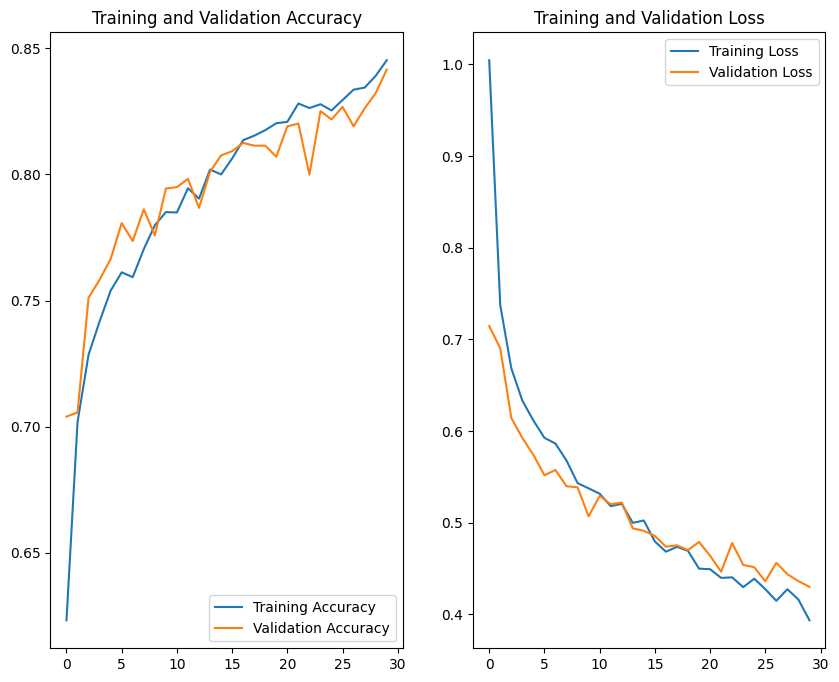

In [10]:
acc= hist['accuracy']
val_acc= hist['val_accuracy']

loss= hist['loss']
val_loss= hist['val_loss']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 8. Saving the Model

In [11]:
model.save('defungi.h5')

In [13]:
score, acc = model.evaluate(validation_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

57/57 [==============================] - 10s 174ms/step - loss: 0.4302 - accuracy: 0.8416
Test Loss = 0.430163711309433
Test Accuracy = 0.8415570259094238
